In [1]:
import backtrader as bt
#import alpaca_backtrader_api as api
#import alpaca_trade_api as tradeapi
import pandas as pd

#from config import *

import yfinance as yf



In [2]:

from typing import Dict, List
from functools import reduce
from pandas import DataFrame
# --------------------------------
import talib.abstract as tab
from typing import Dict, List
from pandas import DataFrame, DatetimeIndex, merge
# --------------------------------
import talib as ta
import numpy

In [3]:
#api = tradeapi.REST(key_id, secret_key)

In [4]:
#get data and turn to dataframe form
#15Min, 5Min
#data=api.get_barset(symbols = ("INTC"), start = '2020-03-27T11:52:00-04:00', end = "2020-01-01", timeframe = "minute", limit=1000)
#df=data.df #converts to dataframe
YDF = yf.download('INTC',start='2020-04-02',end='2020-04-03',interval='1m')

[*********************100%***********************]  1 of 1 completed


In [5]:
#get rid of multiindex, otherwise backtrader will have problems
#df=df.INTC
YDF.iloc[-10]['Close']

54.189998626708984

In [6]:
#form is not compatible with bt strategy but should work with bot algo when that happens
from pandas import DataFrame
def populateindicators(dataframe) -> DataFrame:
        dataframe['ema_high'] = tab.EMA(dataframe, timeperiod=5, price='high')
        dataframe['ema_close'] = tab.EMA(dataframe, timeperiod=5, price='close')
        dataframe['ema_low'] = tab.EMA(dataframe, timeperiod=5, price='low')
        stoch_fast = tab.STOCHF(dataframe, 10.0, 3.0, 0.0, 3.0, 0.0)
        dataframe['fastd'] = stoch_fast['fastd']
        dataframe['fastk'] = stoch_fast['fastk']
        dataframe['adx'] = tab.ADX(dataframe)

        # required for graphing
        bollinger =ta.BBANDS(dataframe.close,timeperiod=10)
        dataframe['bb_lowerband'] = bollinger[2]
        dataframe['bb_upperband'] = bollinger[0]
        dataframe['bb_middleband'] = bollinger[1]

        return dataframe

In [7]:
#feed strat to cerebro

class Scalp(bt.Strategy):
    """
        this strategy is based around the idea of generating a lot of potential buys and make tiny profits on each trade
        we recommend to have at least 60 parallel trades at any time to cover non avoidable losses.
        Recommended is to only sell based on ROI for this strategy
    """ 
#populate a dataframe with indicators
    
    
    
#------------------------------------strategy starts here--------------------------------------------------------------    
    def __init__(self):
        
        #preallocate indicator lsits
        self.emahigh = [False]*len(self.datas)
        self.emaclose = [False]*len(self.datas)
        self.emalow = [False]*len(self.datas)
        self.stoch = [False]*len(self.datas)
        self.fastk = [False]*len(self.datas)
        self.fastd = [False]*len(self.datas)
        self.adx = 
        
        for i,d in enumerate(self.datas)
            #populate exponential moving averages
            self.emahigh[i]=bt.indicators.EMA(self.d.high, period=10)
            self.emaclose[i]=bt.indicators.EMA(self.d.close, period=10)
            self.emalow[i]=bt.indicators.EMA(self.d.low, period=10)
        
            #creat stochastic momentum indicators 
            self.stoch=bt.talib.STOCHF(self.data.high, self.data.low, self.data.close, \
                                       fastk_period=14, slowk_period=4, slowd_period=4)
            self.fastk=self.stoch.fastk
            self.fastd=self.stoch.fastd
            #create Average Directional Movement Index
            self.adx=bt.talib.ADX(self.data.high, self.data.low, self.data.close, timeperiod=14)
        
        
# if open score is less than ema_low, adx is greater than 30, fastk fastd less than 30, then buy
#uses indicators to determine buy and sell

    def next(self):
        if not self.position: #not in the market
            if self.data.open < self.emalow and \
            self.adx > 30 and \
            self.fastk < 30 and \
            self.fastd < 30:
                self.buy(size=200)
                
                
        else:
            if self.data.open >= self.emahigh and \
            self.fastk > 70 and \
            self.fastd > 70:
                self.sell(size=200)


In [8]:

#feed dataframe to cerbro
datacere = bt.feeds.PandasData(dataname=YDF)

#create backtrader
cerebro = bt.Cerebro()

#cerebro.addstrategy(SmaCross)
cerebro.addstrategy(Scalp)

#Add slippage
cerebro.broker = bt.brokers.BackBroker(slip_perc=0.005) 

#set up cerebro
StartCash = 100000 #I would like this number for later
cerebro.broker.setcash(StartCash)

cerebro.broker.setcommission(commission=0.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)
cerebro.adddata(datacere)



In [9]:
#create plotinfo dict for plotting options
plotinfo = dict(plot=True,
                subplot=True,
                plotname='',
                plotskip=False,
                plotabove=False,
                plotlinelabels=False,
                plotlinevalues=True,
                plotvaluetags=True,
                plotymargin=0.0,
                plotyhlines=[],
                plotyticks=[],
                plothlines=[],
                plotforce=False,
                plotmaster=None,
                plotylimited=True,
           )

In [10]:
#change window settings
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 20, 15  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "20"

In [11]:
#Add indicators 

#adding another simple moving average line; this is the backtrader built in indicator
sma = bt.indicators.SimpleMovingAverage(datacere, period=15)
sma.plotinfo.plotname = 'mysma'


macd= bt.indicators.MACD(datacere)
macd.plotinfo.plotname="MACD"
#https://www.backtrader.com/docu/indautoref/
#custom: https://medium.com/@danjrod/custom-indicator-development-in-python-with-backtrader-bc775552dc3e

In [12]:
# Add the analyzers we are interested in
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
cerebro.addanalyzer(bt.analyzers.Returns, _name="ret")
cerebro.addanalyzer(bt.analyzers.PeriodStats, _name="pstat")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="trans")



In [13]:
# Add the observers we are interested in 
#this adds more things to the plot on top of the stocks chart
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.BuySell)


<IPython.core.display.Javascript object>


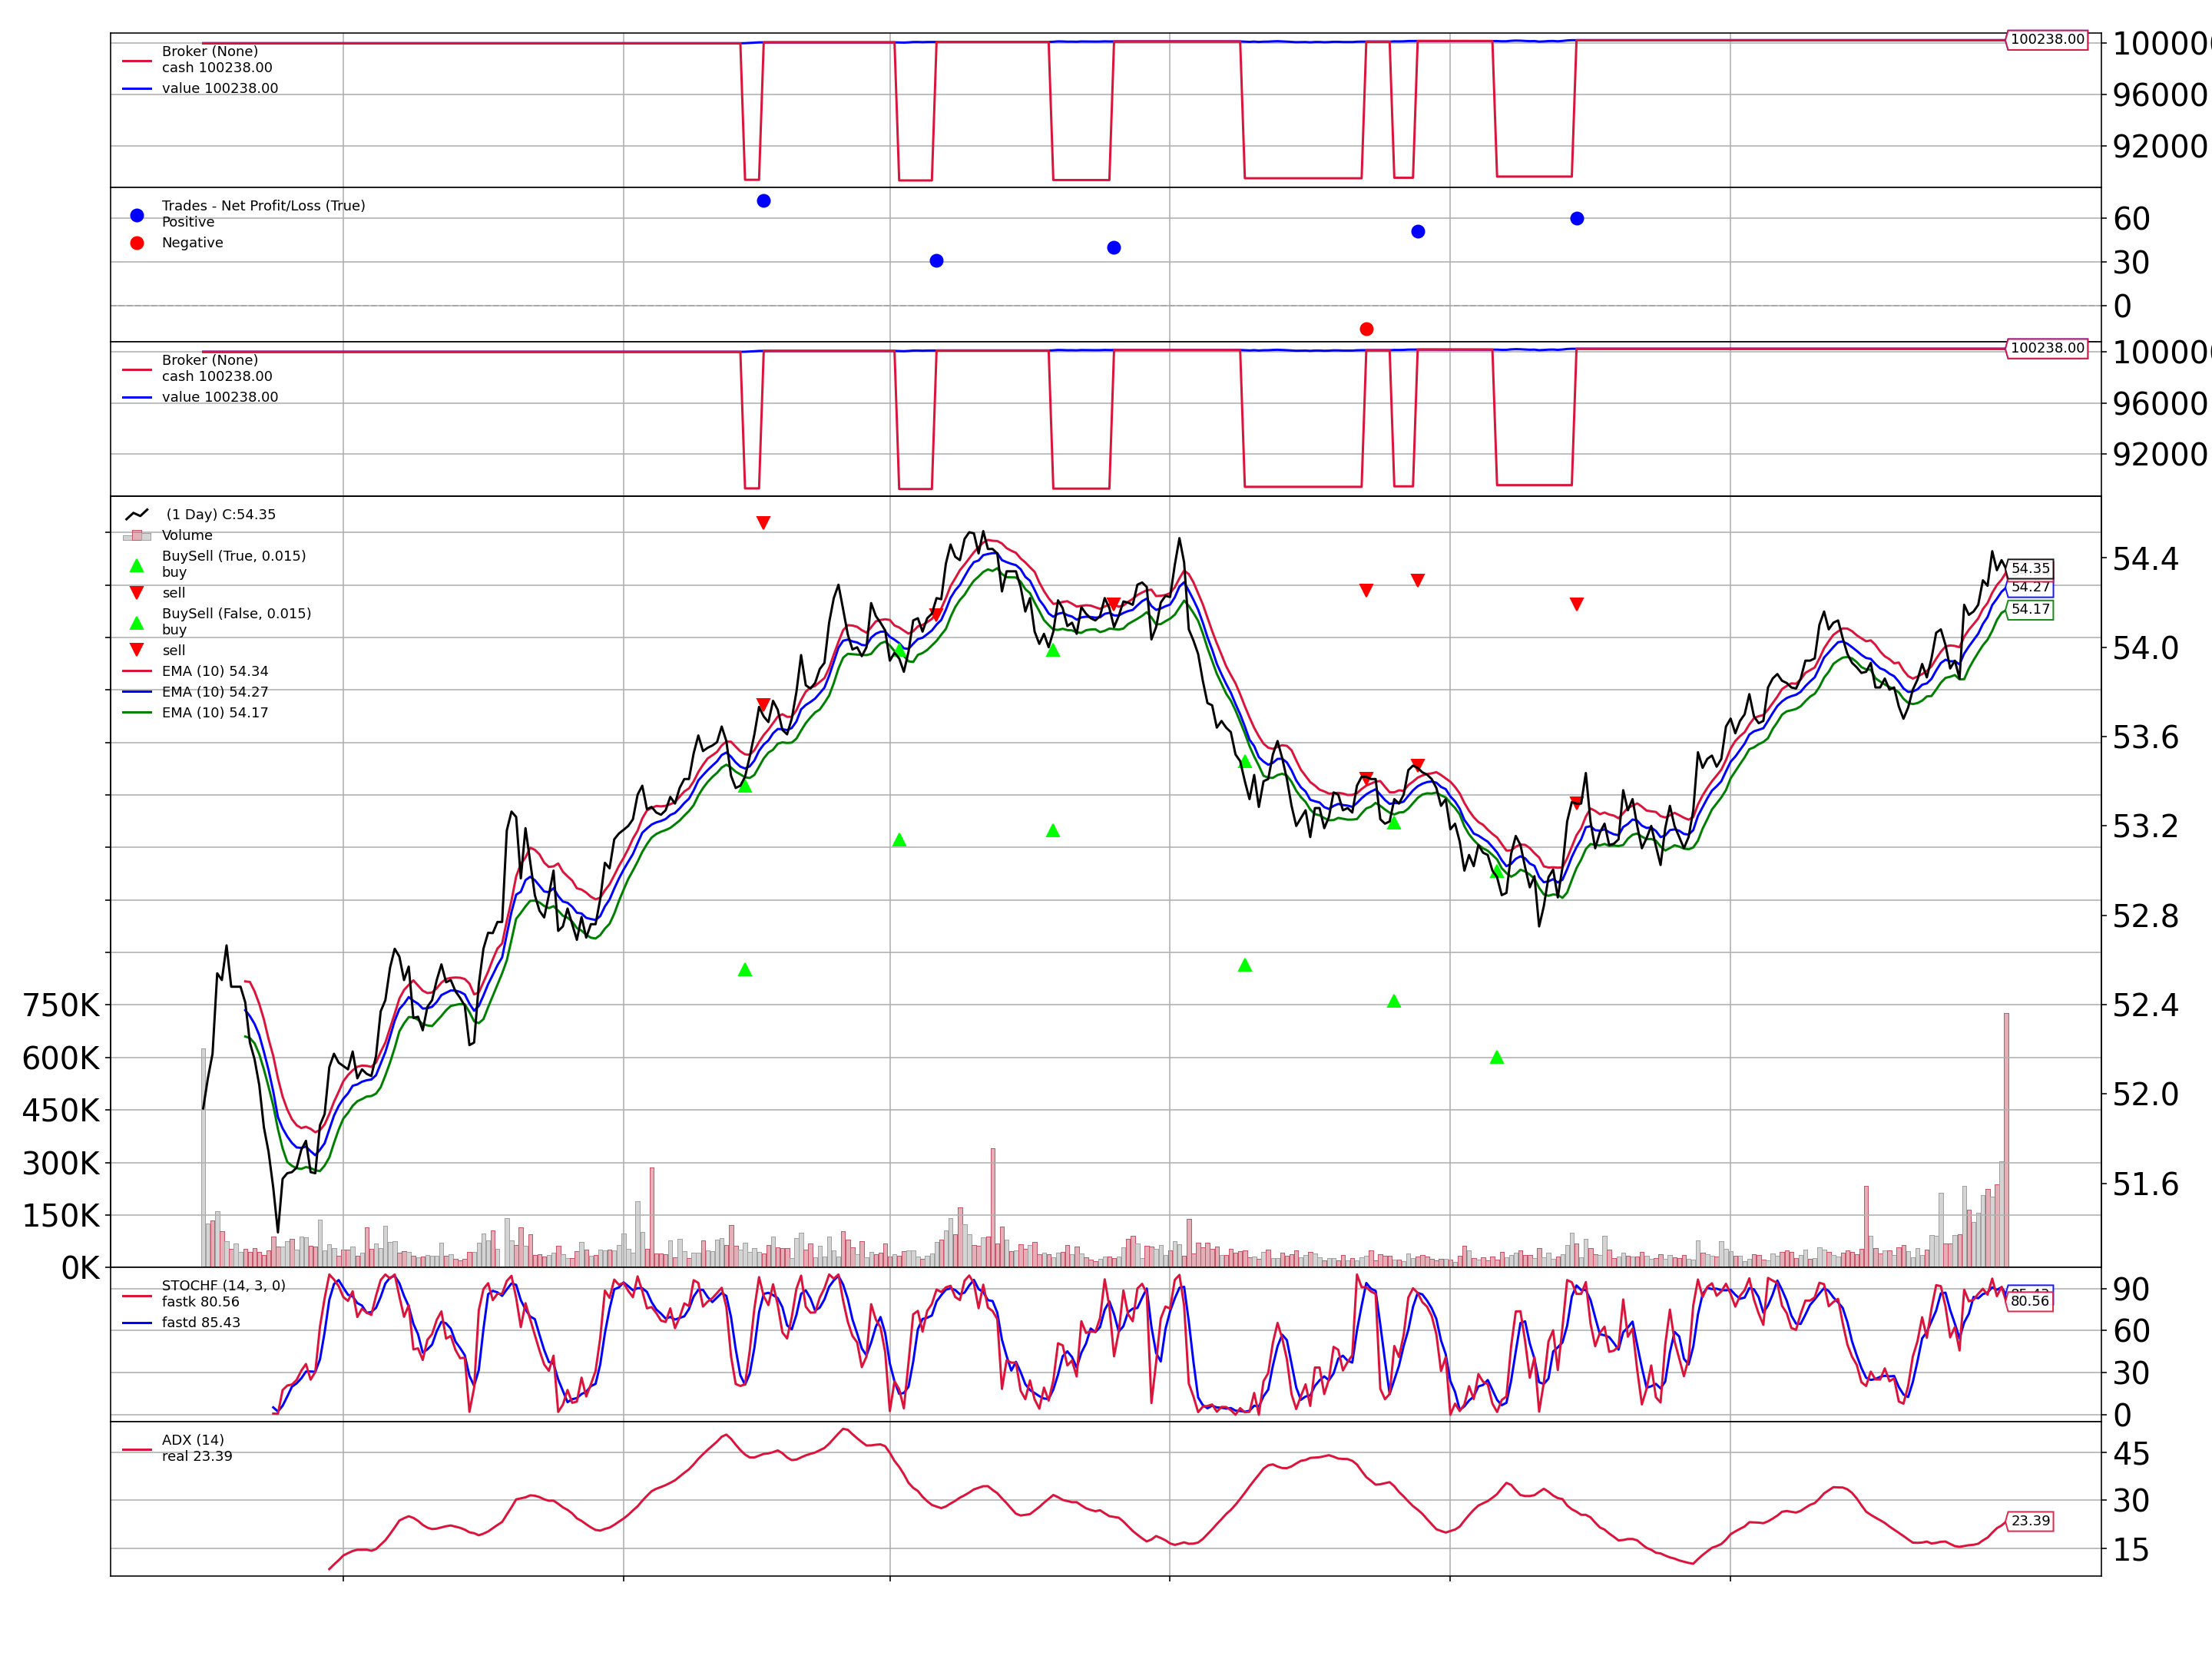

[[<Figure size 1440x1080 with 7 Axes>]]

In [14]:
# Run over everything
test=cerebro.run()

# Plot the result
cerebro.plot()


## Analyzers


In [15]:
# print the SQN analyzers  SystemQualityNumber
#test[0] is the first strategy used. For multiple strategies, use corresponding number in the list.
SQN_dict=test[0].analyzers.sqn.get_analysis() 
tradeanalysis_dict=test[0].analyzers.ta.get_analysis()
ret_dict=test[0].analyzers.ret.get_analysis()
trans_dict=test[0].analyzers.trans.get_analysis()


In [16]:
profit_pi=tradeanalysis_dict['pnl']['gross']['total']/StartCash*100
#pnl stands for profit and loss. The above number is the net percent gain, I think
BNH_profit_pi = (YDF.iloc[0]['Close']-YDF.iloc[-1]['Close'])/YDF.iloc[0]['Close']*100
#Buy and hold profit
print('Strategy Yielded {:2f}% increase compared to {:2f}% for buy and hold'.format(profit_pi,BNH_profit_pi))


Strategy Yielded 0.237999% increase compared to -4.650038% for buy and hold
